# Reaction Diffusion Equation

In order to show scalability and accuracy of the adjoint method for a system of PDEs in a higher dimensional space, let us consider a system of PDEs given by
\begin{flalign}
    &\frac{\partial u}{\partial t} + c_0^u\nabla^2_{{x_1}}[u] + c_1^u\nabla^2_{{x_2}}[u] + R^u(u, v) = 0,\\
    &\frac{\partial v}{\partial t} + c_0^v\nabla^2_{{x_1}}[v] + c_1^v\nabla^2_{{x_2}}[v] + R^v(u, v) = 0
  \end{flalign}
  where
  \begin{flalign}
    R^u(u, v) &= c^u_2 u + c^u_3 u^3 + c^u_4  uv^2 + c^u_5  u^2v + c^u_6 v^3
    \\
    R^v(u, v) &= c^v_2 v + c^v_3 v^3 + c^v_4  vu^2 + c^v_5  v^2u + c^v_6 u^3
\end{flalign}

First, import the adjoint library:

In [2]:
import sys
import os
src_path = os.path.abspath(os.path.join(os.getcwd(), '../src'))
sys.path.append(src_path)
from adjoint import *
size = 6
cm = 0.393701

## Generate Data

We construct the data set by solving the system of PDEs using a 2nd order Finite Difference scheme with initial values
\begin{flalign}
    &u_0 = a \sin\left(\frac{4 \pi x_1}{L_1}\right)  \cos\left(\frac{3\pi x_2}{L_2}\right) \left(L_1x_1-x_1^2\right)  \left(L_2x_2-x_2^2\right)\\
    &v_0 =a \cos\left(\frac{4 \pi x_1}{L_1}\right)  \sin\left(\frac{3\pi x_2}{ L_2}\right)\left(L_1x_1-x_1^2\right)\left(L_2x_2-x_2^2\right)
\end{flalign}
where $a=100$, and the coefficients
\begin{flalign}
    &\boldsymbol c^u = [c^u_i]_{i=0}^6 = [-0.1, -0.2, -0.3, -0.4, 0.1, 0.2, 0.3]\\
    &\boldsymbol c^v = [c^v_i]_{i=0}^6 = [-0.4, -0.3, -0.2, -0.1, 0.3, 0.2, 0.1].
\end{flalign}
We generate data by solving the system of PDEs using the Finite Difference method and forward Euler scheme for $N_t=25$ steps with a time step size of $\Delta t=10^{-6}$, and in the domain $\Omega=[0,L_1]\times [0,L_2]$ where $L_1=L_2=1$ which is discretized using a uniform grid with $N_{x_1}\times N_{x_2}=50^2$ nodes leading to mesh size $\Delta x_1=\Delta x_2 = 0.02$.

In [3]:
## 2D, 2PDE Reaction_diffusion_equation

# u_t + cu0 * u_xx + cu1 * u_yy + cu2 * u + cu3 * u^3 + cu4 * u*v^2 + cu5 * u^2*v + cu6 * v^3 = 0
# v_t + cv0 * v_xx + cv1 * v_yy + cv2 * v + cv3 * v^3 + cv4 * v*u^2 + cv5 * v^2*u + cv6 * u^3 = 0

Nx0 = 50  # Number of grid points in x-direction
Nx1 = 50  # Number of grid points in y-direction
Lx0 = 1.0  # Domain size in x-direction
Lx1 = 1.0  # Domain size in y-direction
V = Lx0*Lx1
dt = 0.000001  # Time step size
Nt = 50

# Discretize the spatial domain
x0 = np.linspace(0, Lx0, Nx0)
x1 = np.linspace(0, Lx1, Nx1)
x = np.array([x0, x1])
dx0 = x0[1] - x0[0]
dx1 = x1[1] - x1[0]
X0, X1 = np.meshgrid(x0, x1)
dx = np.array([dx0, dx1])

# Set initial conditions
f0 = np.array([np.sin(4*np.pi*X0/Lx0) * np.cos(3*np.pi * X1 / Lx1) * X0 * (Lx0-X0) * X1 * (Lx1-X1) * 100,
               np.cos(4*np.pi*X0/Lx0) * np.sin(3*np.pi * X1 / Lx1) * X0 * (Lx0-X0) * X1 * (Lx1-X1) * 100])

def Reaction_diffusion_equation(coefu, coefv, u0_m, v0_m, dx_m, dy_m, dt_m, Nt_m):
    u_m = np.zeros((Nt_m, u0_m.shape[0], u0_m.shape[1]))# (Nt, Nx, Ny)
    v_m = np.zeros((Nt_m, v0_m.shape[0], v0_m.shape[1]))#
    u_m[0,:,:] = u0_m
    v_m[0,:,:] = v0_m
    for i in range(Nt_m-1):
        u_m[i+1,:,:] =  u_m[i,:,:]
        u_m[i+1,:,:] += - dt_m*coefu[0] * np.gradient( np.gradient(u_m[i,:,:],axis=0), axis=0) / dx_m**2 
        u_m[i+1,:,:] += - dt_m*coefu[1] * np.gradient( np.gradient(u_m[i,:,:],axis=1), axis=1) / dy_m**2
        u_m[i+1,:,:] += - dt_m*coefu[2] * u_m[i,:,:]
        u_m[i+1,:,:] += - dt_m*coefu[3] * u_m[i,:,:]**3
        u_m[i+1,:,:] += - dt_m*coefu[4] * u_m[i,:,:]    * v_m[i,:,:]**2
        u_m[i+1,:,:] += - dt_m*coefu[5] * u_m[i,:,:]**2 * v_m[i,:,:]
        u_m[i+1,:,:] += - dt_m*coefu[6] * v_m[i,:,:]**3
        
        v_m[i+1,:,:] =  v_m[i,:,:]
        v_m[i+1,:,:] += - dt_m*coefv[0] * np.gradient( np.gradient(v_m[i,:,:],axis=0), axis=0) / dx_m**2 
        v_m[i+1,:,:] += - dt_m*coefv[1] * np.gradient( np.gradient(v_m[i,:,:],axis=1), axis=1) / dy_m**2
        v_m[i+1,:,:] += - dt_m*coefv[2] * v_m[i,:,:]
        v_m[i+1,:,:] += - dt_m*coefv[3] * v_m[i,:,:]**3
        v_m[i+1,:,:] += - dt_m*coefv[4] * v_m[i,:,:]    * u_m[i,:,:]**2
        v_m[i+1,:,:] += - dt_m*coefv[5] * v_m[i,:,:]**2 * u_m[i,:,:]
        v_m[i+1,:,:] += - dt_m*coefv[6] * u_m[i,:,:]**3
    return u_m, v_m

coefu = [-0.1, -0.2, -0.3, -0.4, 0.1, 0.2, 0.3]
coefv = [-0.4, -0.3, -0.2, -0.1, 0.3, 0.2, 0.1]
coef = np.array([coefu, coefv])
# Generate data
fs0, fs1 = Reaction_diffusion_equation(coefu, coefv, f0[0,:], f0[1,:], dx0, dx1, dt, Nt)
fs = np.array([fs0, fs1])

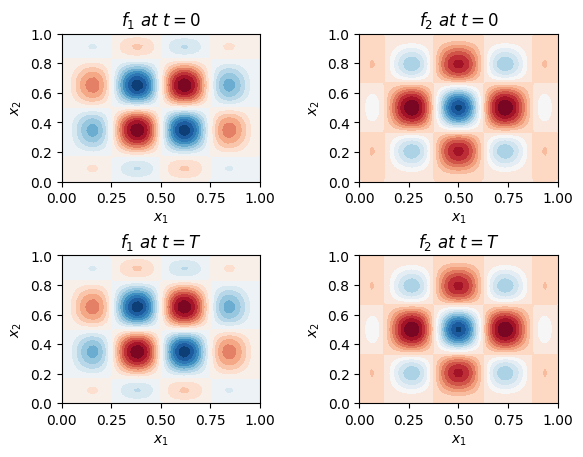

In [31]:
fig, ax = plt.subplots(nrows=2, ncols=2)
ax[0,0].contourf(x[0,:], x[1,:], fs[0,0,:,:], levels=20, cmap="RdBu_r")
ax[0,1].contourf(x[0,:], x[1,:], fs[1,0,:,:], levels=20, cmap="RdBu_r")
ax[0,0].set_title(r"$f_1\ at\ t=0$")
ax[0,1].set_title(r"$f_2\ at\ t=0$")
ax[0,0].set_xlabel(r"$x_1$")
ax[0,0].set_ylabel(r"$x_2$")
ax[0,1].set_xlabel(r"$x_1$")
ax[0,1].set_ylabel(r"$x_2$")

ax[1,0].contourf(x[0,:], x[1,:], fs[0,-1,:,:], levels=20, cmap="RdBu_r")
ax[1,1].contourf(x[0,:], x[1,:], fs[1,-1,:,:], levels=20, cmap="RdBu_r")
ax[1,0].set_title(r"$f_1\ at\ t=T$")
ax[1,1].set_title(r"$f_2\ at\ t=T$")
ax[1,0].set_xlabel(r"$x_1$")
ax[1,0].set_ylabel(r"$x_2$")
ax[1,1].set_xlabel(r"$x_1$")
ax[1,1].set_ylabel(r"$x_2$")

fig.subplots_adjust(hspace=0.5,wspace=0.5)

## Find PDE using the adjoint method

In [6]:
ds = np.array([[0,0], [1,0], [0,1], [2,0], [0,2]])
ps = np.array([[1,0], [0,1], [2,0], [0,2], [2,1], [1,2], [3,0], [0,3]])

beta = 0.004
D = 2
P = 3
numPDE = fs.shape[0]
learning_rates = np.ones((numPDE, len(ds),len(ps)))
for i, d in enumerate(ds):
    for j, p in enumerate(ps):
        learning_rates[:,i,j] = beta * ( min(dx)**(sum(d)-D) ) *10**(P-sum(p))
        if sum(d) == 0:
            learning_rates[:,i,j] *= 70
            
start_time = time.time()
estimated_params, eps, losses = AdjointFindPDE(fs, x, dx, data_dt=dt, avg=False, gamma=1e-3, epochs=400, epthr=400, learning_rates=learning_rates, ds=ds, ps=ps, V=1, tol=1e-15, eps0=1e-16)
end_time = time.time()

print("Execution time: "+str(end_time-start_time))

total number of terms: 80
8.889170866636394e-09


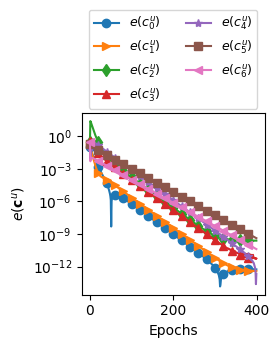

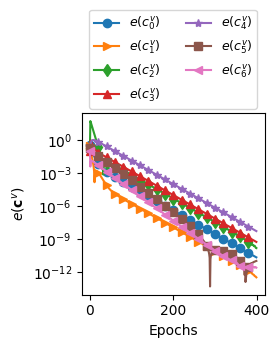

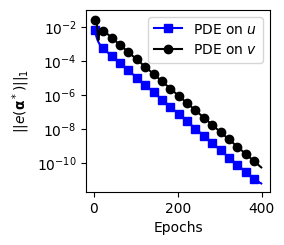

In [7]:
# u_t + cu0 * u_xx + cu1 * u_yy + cu2 * u + cu3 * u^3 + cu4 * u*v^2 + cu5 * u^2*v + cu6 * v^3 = 0
# v_t + cv0 * v_xx + cv1 * v_yy + cv2 * v + cv3 * v^3 + cv4 * v*u^2 + cv5 * v^2*u + cv6 * u^3 = 0
problem = "2D_reaction"
## coeff of u
totalerror = 0
i_pde = 0
plt.figure(figsize=(size*cm, size*cm))
for id, d in enumerate(ds):
    for ip, p in enumerate(ps):
        if d[0]==2 and p[0]==1 and p[1]==0:
            plt.plot(abs(estimated_params[:,i_pde,id,ip]-coefu[0]),#/abs(coefu[0]),
                     label=r"$e(c^u_0)$", marker="o", markevery=20)
            totalerror += abs(estimated_params[-1,i_pde,id,ip]-coefu[0])
for id, d in enumerate(ds):
    for ip, p in enumerate(ps):
        if d[1]==2 and p[0]==1 and p[1]==0:
            plt.plot(abs(estimated_params[:,i_pde,id,ip]-coefu[1]),#/abs(coefu[1]),
                     label=r"$e(c^u_1)$", marker=">", markevery=20)
            totalerror += abs(estimated_params[-1,i_pde,id,ip]-coefu[1])
for id, d in enumerate(ds):
    for ip, p in enumerate(ps):
        if d[0]==0 and d[1]==0 and p[0]==1 and p[1]==0:
            plt.plot(abs(estimated_params[:,i_pde,id,ip]-coefu[2]),#/abs(coefu[2]),
                     label=r"$e(c^u_2)$", marker="d", markevery=20)
            totalerror += abs(estimated_params[-1,i_pde,id,ip]-coefu[2])
for id, d in enumerate(ds):
    for ip, p in enumerate(ps):
        if d[0]==0 and d[1]==0 and p[0]==3 and p[1]==0:
            plt.plot(abs(estimated_params[:,i_pde,id,ip]-coefu[3]),#/abs(coefu[3]),
                     label=r"$e(c^u_3)$", marker="^", markevery=20)
            totalerror += abs(estimated_params[-1,i_pde,id,ip]-coefu[3])
for id, d in enumerate(ds):
    for ip, p in enumerate(ps):
        if d[0]==0 and d[1]==0 and p[0]==1 and p[1]==2:
            plt.plot(abs(estimated_params[:,i_pde,id,ip]-coefu[4]),#/abs(coefu[4]),
                     label=r"$e(c^u_4)$", marker="*", markevery=20)
            totalerror += abs(estimated_params[-1,i_pde,id,ip]-coefu[4])
for id, d in enumerate(ds):
    for ip, p in enumerate(ps):
        if d[0]==0 and d[1]==0 and p[0]==2 and p[1]==1:
            plt.plot(abs(estimated_params[:,i_pde,id,ip]-coefu[5]),#/abs(coefu[5]),
                     label=r"$e(c^u_5)$", marker="s", markevery=20)
            totalerror += abs(estimated_params[-1,i_pde,id,ip]-coefu[5])
for id, d in enumerate(ds):
    for ip, p in enumerate(ps):
        if d[0]==0 and d[1]==0 and p[0]==0 and p[1]==3:
            plt.plot(abs(estimated_params[:,i_pde,id,ip]-coefu[6]),#/abs(coefu[6]),
                     label=r"$e(c^u_6)$", marker="<", markevery=20)
            totalerror += abs(estimated_params[-1,i_pde,id,ip]-coefu[6])
plt.yscale('log')
plt.ylabel(r'$e(\mathbf{c}^u)$')
plt.xlabel('Epochs')
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.6), ncol=2, fontsize=9)
name = problem + "_" + "c_u"
#plt.savefig(name+".pdf",format='pdf', bbox_inches="tight", dpi=300)

## other coeff of u
i_pde = 0


err_otheru = np.zeros_like(estimated_params[:,0,0,0])
countu = 0
for id, d in enumerate(ds):
    for ip, p in enumerate(ps):
        if not (   (d[0]==2 and p[0]==1 and p[1]==0)
                or (d[1]==2 and p[0]==1 and p[1]==0)
                or (d[0]==0 and d[1]==0 and p[0]==1 and p[1]==0)
                or (d[0]==0 and d[1]==0 and p[0]==3 and p[1]==0)
                or (d[0]==0 and d[1]==0 and p[0]==1 and p[1]==2)
                or (d[0]==0 and d[1]==0 and p[0]==2 and p[1]==1)
                or (d[0]==0 and d[1]==0 and p[0]==0 and p[1]==3) ) :
                    err_otheru += abs(estimated_params[:,i_pde,id,ip])
                    countu += 1

## coeff of v
i_pde = 1
plt.figure(figsize=(size*cm, size*cm))
for id, d in enumerate(ds):
    for ip, p in enumerate(ps):
        if d[0]==2 and p[0]==0 and p[1]==1:
            plt.plot(abs(estimated_params[:,i_pde,id,ip]-coefv[0]),#/abs(coefv[0]),
                     label=r"$e(c^v_0)$", marker="o", markevery=20)
            totalerror += abs(estimated_params[-1,i_pde,id,ip]-coefv[0])
for id, d in enumerate(ds):
    for ip, p in enumerate(ps):
        if d[1]==2 and p[0]==0 and p[1]==1:
            plt.plot(abs(estimated_params[:,i_pde,id,ip]-coefv[1]),#/abs(coefv[1]),
                     label=r"$e(c^v_1)$", marker=">", markevery=20)
            totalerror += abs(estimated_params[-1,i_pde,id,ip]-coefv[1])
for id, d in enumerate(ds):
    for ip, p in enumerate(ps):
        if d[0]==0 and d[1]==0 and p[0]==0 and p[1]==1:
            plt.plot(abs(estimated_params[:,i_pde,id,ip]-coefv[2]),#/abs(coefv[2]),
                     label=r"$e(c^v_2)$", marker="d", markevery=20)
            totalerror += abs(estimated_params[-1,i_pde,id,ip]-coefv[2])
for id, d in enumerate(ds):
    for ip, p in enumerate(ps):
        if d[0]==0 and d[1]==0 and p[0]==0 and p[1]==3:
            plt.plot(abs(estimated_params[:,i_pde,id,ip]-coefv[3]),#/abs(coefv[3]),
                     label=r"$e(c^v_3)$", marker="^", markevery=20)
            totalerror += abs(estimated_params[-1,i_pde,id,ip]-coefv[3])
for id, d in enumerate(ds):
    for ip, p in enumerate(ps):
        if d[0]==0 and d[1]==0 and p[0]==2 and p[1]==1:
            plt.plot(abs(estimated_params[:,i_pde,id,ip]-coefv[4]),#/abs(coefv[4]),
                     label=r"$e(c^v_4)$", marker="*", markevery=20)
            totalerror += abs(estimated_params[-1,i_pde,id,ip]-coefv[4])
for id, d in enumerate(ds):
    for ip, p in enumerate(ps):
        if d[0]==0 and d[1]==0 and p[0]==1 and p[1]==2:
            plt.plot(abs(estimated_params[:,i_pde,id,ip]-coefv[5]),#/abs(coefv[5]),
                     label=r"$e(c^v_5)$", marker="s", markevery=20)
            totalerror += abs(estimated_params[-1,i_pde,id,ip]-coefv[5])
for id, d in enumerate(ds):
    for ip, p in enumerate(ps):
        if d[0]==0 and d[1]==0 and p[0]==3 and p[1]==0:
            plt.plot(abs(estimated_params[:,i_pde,id,ip]-coefv[6]),#/abs(coefv[6]),
                     label=r"$e(c^v_6)$", marker="<", markevery=20)
            totalerror += abs(estimated_params[-1,i_pde,id,ip]-coefv[6])
plt.yscale('log')
plt.ylabel(r'$e(\mathbf{c}^v)$')
plt.xlabel('Epochs')
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.6), ncol=2, fontsize=9)
name = problem + "_" + "c_v"
#plt.savefig(name+".pdf",format='pdf', bbox_inches="tight", dpi=300)

err_otherv = np.zeros_like(estimated_params[:,1,0,0])
countv = 0
for id, d in enumerate(ds):
    for ip, p in enumerate(ps):
        if not (   (d[0]==2 and p[0]==0 and p[1]==1)
                or (d[1]==2 and p[0]==0 and p[1]==1)
                or (d[0]==0 and d[1]==0 and p[0]==0 and p[1]==1)
                or (d[0]==0 and d[1]==0 and p[0]==0 and p[1]==3)
                or (d[0]==0 and d[1]==0 and p[0]==2 and p[1]==1)
                or (d[0]==0 and d[1]==0 and p[0]==1 and p[1]==2)
                or (d[0]==0 and d[1]==0 and p[0]==3 and p[1]==0) ) :
                    err_otherv += abs(estimated_params[:,i_pde,id,ip])
                    countv += 1
            

plt.figure(figsize=(size*cm, size*cm))

plt.plot(eps[2:], err_otheru[2:]/countu, marker="s", markevery=20, label=r"PDE on $u$", color="blue")
plt.plot(eps[2:], err_otherv[2:]/countv, marker="o", markevery=20, label=r"PDE on $v$", color="black")
plt.legend()
plt.yscale('log')
plt.ylabel(r'$||e(\mathbf{\alpha}^*)||_1$')
plt.xlabel('Epochs')
name = problem + "_" + "other_alphas"
#plt.savefig(name+".pdf",format='pdf', bbox_inches="tight", dpi=300)

print("total number of terms: "+str(numPDE*len(ds)*len(ps)))

totalerror += err_otheru[-1]
totalerror += err_otherv[-1]
print(totalerror)


